In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../../..")

In [3]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.INFO)

In [4]:
dataset = "mnist"
algo = "modular"
prefilter_strategy = "oracle"
scorer = "cross_entropy"

experiment_folder = "experiment_results"
experiment_name = "vanilla_fix_bug_compute_loss_encodev2"

use_contrastive = True
num_trains_per_class = 64
seed = 0
num_neighbors = 10
parallel = False


save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg = get_cfg(
    save_dir)


# train_cfg['num_epochs'] = 10
train_cfg['component_update_freq'] = train_cfg['num_epochs']
# num_comms_per_task = 3 # should really add 1 because the last comm is kinda basically useless
num_comms_per_task = 6 # should really add 1 because the last comm is kinda basically useless
# for the current task.
comm_freq = train_cfg['num_epochs'] // num_comms_per_task

shared_memory_size = 200

cfg.sharing_strategy = DictConfig({
    "name": "recv_data",
    "scorer": scorer,
    "num_queries": 10,
    'num_data_neighbors': 5,
    'num_filter_neighbors': 5,
    'num_coms_per_round': 2,
    "query_score_threshold": 0.0,
    "shared_memory_size": shared_memory_size,
    # "shared_memory_size": 10,
    "comm_freq": comm_freq,
    "prefilter_strategy": prefilter_strategy,
    "use_ood_separation_loss": False,
})

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)


INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


In [5]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel)
FleetCls = get_fleet(cfg.sharing_strategy, parallel)

In [6]:
def setup_fleet(task_id=None): 
    fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)
    if task_id is not None:
        fleet.load_model_from_ckpoint(task_ids=task_id)
        fleet.update_replay_buffers(task_id)
    return fleet

In [7]:
fleet = setup_fleet(task_id=3)

INFO:root:Agent: node_id: 0, seed: 0


INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


In [8]:
# """
# Viz query. Each row is a task. Each column is a query.
# The label is {score}/{y}/{y_pred}, and
# `red` means y != y_pred, `green` means y == y_pred.
# """
# agent_id = 0
# query_task_id = 0
# agent = fleet.agents[agent_id]
# X_queries, y_queries, y_pred_queries, score_queries = agent.compute_query(task_id=4, debug_return=True)

# num_neighbors = len(X_queries.keys())
# num_queries = max([len(X_queries[i]) for i in range(num_neighbors)])
# fig, axes = plt.subplots(num_neighbors, num_queries, figsize=(num_queries*2, num_neighbors*2))

# rows = [f"task {task_id}" for task_id in range(num_neighbors)]
# pad = 0
# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center', rotation=90)

# for task_id in range(num_neighbors):
#     for query_id in range(len(X_queries[task_id])):
#         ax = axes[task_id, query_id]
#         ax.set_xticks([])
#         ax.set_yticks([])

#         ax.imshow(X_queries[task_id][query_id].squeeze(), cmap="gray")
#         color = "green" if y_queries[task_id][query_id]  ==  y_pred_queries[task_id][query_id] else "red"
#         ax.set_title(f"{score_queries[task_id][query_id]:.2f}/{y_queries[task_id][query_id]}/{y_pred_queries[task_id][query_id]}",
#                      color=color)

   
# plt.tight_layout()

In [9]:
# fleet.communicate(task_id=4)

In [10]:
# neighbor_data = [agent.incoming_extra_info[neigh_id]['X_neighbors'][query_task_id] for neigh_id in agent.incoming_data.keys()]
# neighbor_data = [task_data.reshape(-1, *task_data.shape[2:]) for task_data in neighbor_data]

# # Calculate number of rows (tasks) and columns (queries)
# num_neighbors = len(neighbor_data)
# num_queries = max([len(data) for data in neighbor_data])  # Assuming each task has a list of data

# # Create subplots
# fig, axes = plt.subplots(num_neighbors, num_queries, figsize=(num_queries * 2, num_neighbors * 2))

# # Set row labels
# rows = [f"neighbor {neigh_id}" for neigh_id in agent.incoming_data.keys()]
# pad = 0
# for ax, row in zip(axes[:, 0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center', rotation=90)

# # Plot data
# for task_id, task_data in enumerate(neighbor_data):
#     for query_id in range(len(task_data)):
#         ax = axes[task_id, query_id]
#         ax.set_xticks([])
#         ax.set_yticks([])

#         ax.imshow(task_data[query_id].squeeze(), cmap="gray")

# plt.tight_layout()

In [11]:
# replay = agent.agent.shared_replay_buffers[query_task_id]
# plt.imshow(make_grid(replay.tensors[0][:len(replay)]).permute(1,2,0));

## The performance of baseline fleet

In [12]:
test_task_id = 4
fleet = setup_fleet(task_id=test_task_id)
baseline_perfs = fleet.eval_test(test_task_id)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


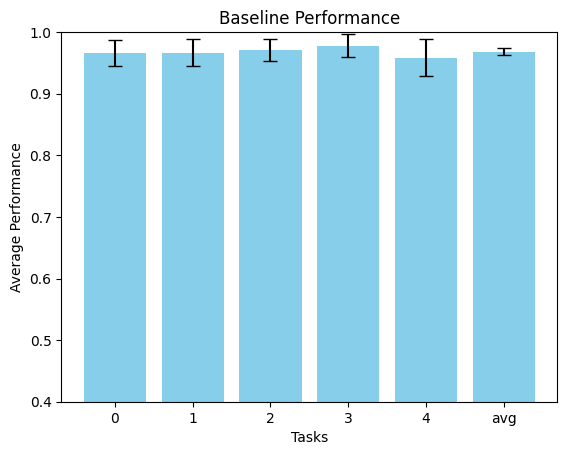

In [13]:
df = pd.DataFrame(baseline_perfs)
df.columns = df.columns.astype(str)

task_stats = df.agg(["mean", "std"])
plt.bar(task_stats.columns, task_stats.loc['mean'], yerr=task_stats.loc['std'], capsize=5, color='skyblue')
plt.xlabel('Tasks')
plt.ylabel('Average Performance')
plt.title('Baseline Performance')
plt.ylim(0.4, 1.0)  
plt.show()

In [14]:
task_stats

,0,1,2,3,4,avg
mean,0.965758,0.966875,0.971429,0.977758,0.958175,0.967999
std,0.020935,0.021769,0.017790,0.018548,0.030025,0.005467


In [15]:
# len(agent.dataset.trainset[task_id].tensors)

In [16]:
# from shell.fleet.fleet import CustomConcatDataset
# from shell.datasets.datasets import get_custom_tensordataset
# from torch.utils.data.dataset import ConcatDataset

# task_id = 4
# fleet = setup_fleet(task_id=task_id)
# agent = fleet.agents[0]
# dataset = deepcopy(agent.dataset.trainset[task_id])

# n = 100
# X = torch.zeros((n, 1, 28, 28))
# y = torch.zeros(n, dtype=torch.long)

# agent.agent.shared_replay_buffers[task_id] = ReplayBufferReservoir(
#             10000, task_id)
# agent.agent.shared_replay_buffers[task_id].push(
#     X, y
# )

# agent.agent.make_shared_memory_loaders(
#             batch_size=agent.batch_size)

# if task_id in agent.agent.shared_memory_loaders:
#     print("adding shared memory")
#     loader = agent.agent.shared_memory_loaders[task_id]
#     shared_tensors = loader.dataset.get_tensors()  # X, y, t
#     # throw away the task id
#     shared_tensors = shared_tensors[:2]
#     dataset = CustomConcatDataset(
#         dataset.tensors, shared_tensors)
#     dataset = get_custom_tensordataset(dataset.tensors, name=agent.dataset.name,
#                                         use_contrastive=agent.agent.use_contrastive)
                                                



# # dataset.tensors = dataset.tensors + \
# #             (torch.full((len(dataset),), task_id, dtype=int),)

# # tmp_dataset = dataset

# # mega_dataset = ConcatDataset(
# #             [get_custom_tensordataset(loader.dataset.get_tensors(), name=agent.dataset.name,
# #                                       use_contrastive=agent.agent.use_contrastive) for t, loader in agent.agent.memory_loaders.items() if t != task_id] + [tmp_dataset]
# #             + [get_custom_tensordataset(loader.dataset.get_tensors(), name=agent.agent.dataset_name,
# #                                         use_contrastive=agent.agent.use_contrastive) for t, loader in agent.agent.shared_memory_loaders.items()
# #                if t != task_id]
# #         )

# # mega_dataset = dataset

# # mega_loader = torch.utils.data.DataLoader(mega_dataset,
# #                                                   batch_size=32,
# #                                                   shuffle=True,
# #                                                   num_workers=0,
# #                                                   pin_memory=True
# #                                                   )


In [17]:
# len(dataset)

In [18]:
# for X, Y, t in mega_loader:
#     print('X', type(X), X[0].shape, X[1].shape)
#     print(Y.shape, t.shape)

In [19]:
# len(mega_dataset)

In [20]:
# dataset.tensors[0].shape, dataset.tensors[1].shape, dataset.tensors[2].shape

In [21]:
# len(agent.agent.shared_replay_buffers[task_id].get_tensors())

## Receiver Sharing

In [22]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel=True)
FleetCls = get_fleet(cfg.sharing_strategy, parallel=True)

fleet = setup_fleet(task_id=test_task_id-1)
before_sharing_and_learn = fleet.eval_test(test_task_id)

INFO:root:No. gpus per agent: 0.25


2024-02-05 15:38:52,417	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(ParallelRecvDataAgent pid=2038057) INFO:root:Agent: node_id: 0, seed: 0
(ParallelRecvDataAgent pid=2038059) INFO:root:Agent: node_id: 2, seed: 2000
(ParallelRecvDataAgent pid=2038058) INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
(ParallelRecvDataAgent pid=2038102) INFO:root:Agent: node_id: 3, seed: 3000
(ParallelRecvDataAgent pid=2038178) INFO:root:Agent: node_id: 4, seed: 4000
(ParallelRecvDataAgent pid=2038304) INFO:root:Agent: node_id: 6, seed: 6000
(ParallelRecvDataAgent pid=2038242) INFO:root:Agent: node_id: 5, seed: 5000
(ParallelRecvDataAgent pid=2038366) INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Fleet initialized


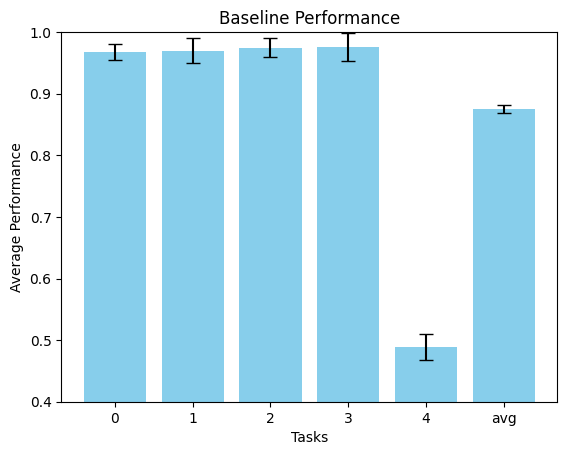

In [23]:
df = pd.DataFrame(before_sharing_and_learn)
df.columns = df.columns.astype(str)

task_stats = df.agg(["mean", "std"])
plt.bar(task_stats.columns, task_stats.loc['mean'], yerr=task_stats.loc['std'], capsize=5, color='skyblue')
plt.xlabel('Tasks')
plt.ylabel('Average Performance')
plt.title('Baseline Performance')
plt.ylim(0.4, 1.0)  
plt.show()

In [24]:
print(fleet.get_save_dir())
fleet.change_save_dir('experiment_results/test_recv_global_labels')
print(fleet.get_save_dir())

['experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_0', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_1', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_2', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_3', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_4', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_5', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_6', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/

In [25]:
fleet.train_and_comm(task_id=test_task_id)

(ParallelRecvDataAgent pid=2038059) INFO:root:epochs: 0, training task: 4
(ParallelRecvDataAgent pid=2038059) INFO:root:	task: 0	loss: 0.39762004	acc: 0.965
(ParallelRecvDataAgent pid=2038059) INFO:root:	task: 1	loss: 0.37774693	acc: 0.954
(ParallelRecvDataAgent pid=2038059) INFO:root:	task: 2	loss: 0.37510298	acc: 0.988
(ParallelRecvDataAgent pid=2038059) INFO:root:	task: 3	loss: 0.38231540	acc: 0.981
(ParallelRecvDataAgent pid=2038059) INFO:root:	task: 4	loss: 0.69469342	acc: 0.458
(ParallelRecvDataAgent pid=2038059) INFO:root:	task: avg	loss: 0.44549575	acc: 0.869
(ParallelRecvDataAgent pid=2038058) INFO:root:epochs: 0, training task: 4
(ParallelRecvDataAgent pid=2038058) INFO:root:	task: 0	loss: 0.37953345	acc: 0.970
(ParallelRecvDataAgent pid=2038058) INFO:root:	task: 1	loss: 0.35447751	acc: 0.975
(ParallelRecvDataAgent pid=2038058) INFO:root:	task: 2	loss: 0.38573264	acc: 0.966
(ParallelRecvDataAgent pid=2038058) INFO:root:	task: 3	loss: 0.40629087	acc: 0.988
(ParallelRecvDataAge

training from 0 to 16
comm at epoch 16


(ParallelRecvDataAgent pid=2038178) INFO:root:epochs: 21, training task: 4
(ParallelRecvDataAgent pid=2038178) INFO:root:	task: 0	loss: 0.39294464	acc: 0.989
(ParallelRecvDataAgent pid=2038178) INFO:root:	task: 1	loss: 0.37747095	acc: 0.979
(ParallelRecvDataAgent pid=2038178) INFO:root:	task: 2	loss: 0.43704142	acc: 0.943
(ParallelRecvDataAgent pid=2038178) INFO:root:	task: 3	loss: 0.35984711	acc: 0.986
(ParallelRecvDataAgent pid=2038178) INFO:root:	task: 4	loss: 0.70574645	acc: 0.476
(ParallelRecvDataAgent pid=2038178) INFO:root:	task: avg	loss: 0.45461011	acc: 0.875
(ParallelRecvDataAgent pid=2038366) INFO:root:epochs: 21, training task: 4
(ParallelRecvDataAgent pid=2038366) INFO:root:	task: 0	loss: 0.37277447	acc: 0.977
(ParallelRecvDataAgent pid=2038366) INFO:root:	task: 1	loss: 0.45240000	acc: 0.928
(ParallelRecvDataAgent pid=2038366) INFO:root:	task: 2	loss: 0.38272549	acc: 0.981
(ParallelRecvDataAgent pid=2038366) INFO:root:	task: 3	loss: 0.37253642	acc: 0.965
(ParallelRecvDataA

training from 16 to 32
comm at epoch 32


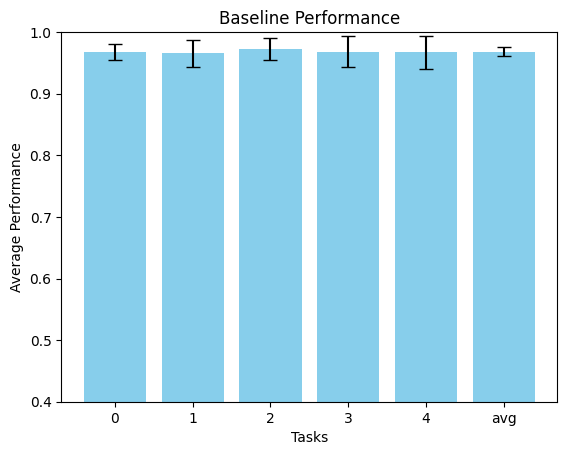

In [ ]:
after_sharing_and_learn = fleet.eval_test(test_task_id)
df = pd.DataFrame(after_sharing_and_learn)
df.columns = df.columns.astype(str)

task_stats = df.agg(["mean", "std"])
plt.bar(task_stats.columns, task_stats.loc['mean'], yerr=task_stats.loc['std'], capsize=5, color='skyblue')
plt.xlabel('Tasks')
plt.ylabel('Average Performance')
plt.title('Baseline Performance')
plt.ylim(0.4, 1.0)  
plt.show()

In [ ]:
task_stats

,0,1,2,3,4,avg
mean,0.967657,0.965499,0.972772,0.968493,0.967331,0.968350
std,0.013220,0.022363,0.017461,0.024640,0.026662,0.006793
